In [1]:
import os
import numpy
import numpy as np
import xarray as xray
import netCDF4
from scipy import stats
from scipy import io
from netCDF4 import Dataset
from scipy import interpolate as naiso

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from sstanalysis import pop_spectra
reload(pop_spectra)

<module 'sstanalysis.pop_spectra' from 'sstanalysis/pop_spectra.pyc'>

In [3]:
basedir = '/data/scratch/takaya/POP_data/'

In [4]:
dlat, dlon = (10., 10.)
lat_start, lat_end = (-60., 50.)
lon_start, lon_end = (5, 345.)
west, south = (lon_start, lat_start)
east, north = (west+dlon, south+dlat)
Degx, Degy = (int((lon_end-lon_start)/dlon), int((lat_end-lat_start)/dlat))
lon_global = numpy.arange(lon_start, lon_end+2*dlon, dlon)
lat_global = numpy.arange(lat_start, lat_end+2*dlat, dlat)
Lon_global, Lat_global = numpy.meshgrid(lon_global, lat_global)

print Degx, Degy, (Degx+1)*(Degy+1)
print Lon_global.shape

34 11 420
(13, 36)


In [5]:
roll = -1080

fname = os.path.join(basedir, 'Surface_Daily/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-02-01.nc')
f = xray.open_dataset(fname, decode_times=False)
mask = f.variables['KMT'].values <= 1
tlon = numpy.roll(f.variables['TLONG'].where(~mask).values, roll, axis=1)
tlat = numpy.roll(f.variables['TLAT'].where(~mask).values, roll, axis=1)
Dz = f['dz'].values[0]  # centimeters


lonrange=numpy.array([lon_start, lon_end])
latrange=numpy.array([lat_start, lat_end+5.])
lonmask = (tlon >= lonrange[0]) & (tlon < lonrange[1])
latmask = (tlat >= latrange[0]) & (tlat < latrange[1])
boxidx = lonmask & latmask # this won't necessarily be square
irange = numpy.where(boxidx.sum(axis=0))[0]
imin_bound, imax_bound = irange.min(), irange.max()
jrange = numpy.where(boxidx.sum(axis=1))[0]
jmin_bound, jmax_bound = jrange.min(), jrange.max()


npzfile = numpy.load(os.path.join(basedir, 'interpLatnLon.npz'))
print npzfile.files
tlat = npzfile['arr_0']
tlon = npzfile['arr_1']

['arr_1', 'arr_0']


In [72]:
print Dz

1000.0


In [34]:
def calc_transformation_rates(pop_fname, dz, daylag=13, daystart=0, Nt=31):
    
    from sstanalysis import pop_spectra
    reload(pop_spectra)
    
    p = pop_spectra.POPFile(pop_fname, areaname='UAREA', maskname='KMU', hconst=dz)
    p.initialize_gradient_operator(field='momentum')
    mask = p.nc.KMU > 1
    U = p.nc.U1_1.where(mask).values
    V = p.nc.V1_1.where(mask).values

    # calculate density fluxes
    Udiss, Vdiss = [dz * t for t in p.biharmonic_tendency('momentum', U, V)]
    
    return p, Udiss, Vdiss

In [7]:
#########
month = 1
#########
##########
daystart = 1
daylag = 13
Ntmonth = 31
##########
# year = range(34)
# years = numpy.append(year, range(35,41))
years = range(1)
fname_mat = ['' for x in range(len(years))]

t = 0
for yearnum in years:
    fname = os.path.join(basedir,
                                 'Surface_Daily/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.%04d-%02d-01.nc' 
                                 % (yearnum+46, month))
    fname_mat[t] = fname
    f = netCDF4.Dataset(fname)
    t += 1
#     print yearnum+46
        
    #for i in range(Nt):
        #SSH_masked[i] = 1e-2*np.roll(np.ma.masked_array(f.variables['SSH_2'][i],mask), roll, axis=1)
    
    #SSH_full[Nt*yearnum:Nt*yearnum+Nt] = SSH_masked[:, jmin_bound:jmax_bound+100, imin_bound:imax_bound+100] 
    
mask_global = numpy.roll(mask, roll, axis=1)[jmin_bound:jmax_bound+100, imin_bound:imax_bound+100]
print fname_mat
    
Ny, Nx = tlon.shape

['/data/scratch/takaya/POP_data/Surface_Daily/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-01-01.nc']


46 428


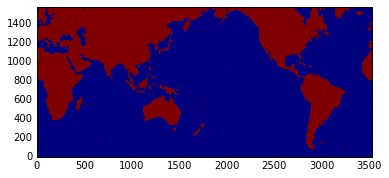

In [26]:
print imin_bound, jmin_bound
plt.imshow(mask_global, origin='bottom')

In [35]:
crit = 0.01
j,i = (0,0)
west, south = (lon_start, lat_start)
east, north = (west+dlon, south+dlat)

N = 64

isospecs_month_Udiss = numpy.zeros(N)
isospecs_month_Vdiss = isospecs_month_Udiss.copy()
isospecs_month_U = isospecs_month_Udiss.copy()
isospecs_month_V = isospecs_month_Udiss.copy()

Kis_month = numpy.zeros(N)
Mrs_month = numpy.zeros(N)

In [36]:
for yearnum in range(len(fname_mat)):
    print 'yearnum:', yearnum

#     ###############
#     # convert units to MKS
#     ###############
#     p.nc['U_diss'] = xray.DataArray( 1e-6 * Udiss, dims=p.nc['U1_1'].dims, coords=p.nc['U1_1'].coords )
#     p.nc['V_diss'] = xray.DataArray( 1e-6 * Vdiss, dims=p.nc['V1_1'].dims, coords=p.nc['V1_1'].coords )
#     p = pop_spectra.POPFile(fname_mat[0], areaname='UAREA', maskname='KMU', hconst=Dz)
#     momDissnpz = np.load(os.path.join(basedir, 
#                                       'Momentum_Biharmonic_closure%04d_%02d.npz' % (yearnum+46, month)))
#     hduk = momDissnpz['hduk']
#     hdvk = momDissnpz['hdvk']
    
    p, Udiss, Vdiss = calc_transformation_rates(fname_mat[yearnum], Dz, Nt=Ntmonth)
    
    p.nc['Udiss'] = xray.DataArray(1e-6*Udiss, dims=p.nc['U1_1'].dims, coords=p.nc['U1_1'].coords)
    p.nc['Vdiss'] = xray.DataArray(1e-6*Vdiss, dims=p.nc['V1_1'].dims, coords=p.nc['V1_1'].coords)
    
    j = 0
    south = 30.
    north = south + dlat
    while south < 40.:
        print 'j:', j
        west = 155.
        east = west+dlon
        i = 0
        if south < 40.:
            while west < 165.:
                print 'i:', i

    #             print east, west, south, north

                lonrange = numpy.array([west, east])
                latrange = numpy.array([south, north])
                lonmask = (tlon >= lonrange[0]) & (tlon < lonrange[1])
                latmask = (tlat >= latrange[0]) & (tlat < latrange[1])
                boxidx = lonmask & latmask # this won't necessarily be square
                irange = numpy.where(boxidx.sum(axis=0))[0]
                imin, imax = irange.min(), irange.max()
                jrange = numpy.where(boxidx.sum(axis=1))[0]
                jmin, jmax = jrange.min(), jrange.max()
                print imin, imax, jmin, jmax

                region_mask = mask_global[jmin:jmax, imin:imax]
                Ny, Nx = region_mask.shape
                land_fraction = region_mask.sum().astype('f8') / (Ny*Nx)
                #SSH_domain = SSH[..., jmin:jmax, imin:imax]
    
            
                if west < lon_end:
                    if land_fraction < crit:
                        print crit
                        
                        ###########
                        # zonal KE
                        ###########
                        Neff, k, l, Ki, isospec, area = p.iso_wvnum_spectra(
                                                'KMU', 'DXU', 'DYU', False, roll, N, crit,
                                                imin, imax, jmin, jmax, 
                                                jmin_bound, jmax_bound, imin_bound, imax_bound,
                                                daylag, daystart, "U1_1")
                        
                        isospecs_month_U[:] += isospec[1:]
                        
                        ###########
                        # meridional KE
                        ###########
                        Neff, k, l, Ki, isospec, area = p.iso_wvnum_spectra(
                                                'KMU', 'DXU', 'DYU', False, roll, N, crit,
                                                imin, imax, jmin, jmax, 
                                                jmin_bound, jmax_bound, imin_bound, imax_bound,
                                                daylag, daystart, "V1_1")
                        
                        isospecs_month_V[:] += isospec[1:]
                        
                        ###########
                        # U dissipation
                        ###########
                        Neff, k, l, Ki, isospec, area = p.iso_wvnum_spectra(
                                                'KMU', 'DXU', 'DYU', False, roll, N, crit,
                                                imin, imax, jmin, jmax, 
                                                jmin_bound, jmax_bound, imin_bound, imax_bound,
                                                daylag, daystart, "U1_1", "Udiss")
                        
                        isospecs_month_Udiss[:] += isospec[1:]
#                         print 'Temp forcing OK'

                        ###########
                        # V dissipation
                        ###########
                        Neff, k, l, Ki, isospec, area = p.iso_wvnum_spectra(
                                                'KMU', 'DXU', 'DYU', False, roll, N, crit,
                                                imin, imax, jmin, jmax, 
                                                jmin_bound, jmax_bound, imin_bound, imax_bound,
                                                daylag, daystart, "V1_1", "Vdiss")

                        isospecs_month_Vdiss[:] += isospec[1:]
                        Kis_month[:] = Ki[1:]
                        Mrs_month[:] = area
#                         print 'Salinity forcing OK'
               
                    else:
                        if yearnum == 0:
                            isospecs_month_U[:] = numpy.nan
                            isospecs_month_V[:] = numpy.nan
                            isospecs_month_Udiss[:] = numpy.nan
                            isospecs_month_Vdiss[:] = numpy.nan

                            Kis_month[:] = numpy.nan
                            Mrs_month[:] = numpy.nan
                        else:
                            pass
                        print "land fraction is too high"
                        break
                        

                west = east
                east = west+dlon
                i += 1
    
        south = north
        north = south+dlat
        j += 1    

yearnum: 0
j: 0
i: 0
1524 1623 1066 1171
0.01


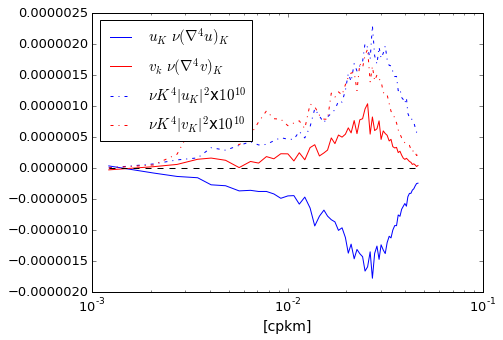

In [37]:
fig = plt.figure(figsize=(7,5))
ax = plt.gca()
ax.semilogx(Kis_month[:-1]*1e3, isospecs_month_Udiss[:-1]/3., 
            'b', label=r'$u_K$ $\nu (\nabla^4 u)_K$')
ax.semilogx(Kis_month[:-1]*1e3, isospecs_month_Vdiss[:-1]/3., 
            'r', label=r'$v_k$ $\nu (\nabla^4 v)_K$')
ax.semilogx(Kis_month[:-1]*1e3, 
            2.7e10*(Kis_month[:-1]*1e3)**4 * isospecs_month_U[:-1]/3.*1e-10, 
            'b-.', label=r'$\nu K^4 |u_K|^2$x$10^{10}$')
ax.semilogx(Kis_month[:-1]*1e3, 
            2.7e10*(Kis_month[:-1]*1e3)**4 * isospecs_month_V[:-1]/3.*1e-10, 
            'r-.', label=r'$\nu K^4 |v_K|^2$x$10^{10}$')
ax.semilogx(Kis_month[:-1]*1e3, numpy.zeros(len(Kis_month[:-1])), 'k--')
# ax.set_ylabel(r'[m$^2$/s$^3$]', fontsize=14)
ax.set_xlabel(r'[cpkm]', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper left', fontsize=15)

In [20]:
Jannpz = numpy.load(os.path.join(basedir, 'Momentum_Biharmonic_closure0046_01.npz'))
print Jannpz.files
Udiss_Jan = Jannpz['hduk']
Vdiss_Jan = Jannpz['hdvk']

['hdvk', 'hduk']


In [33]:
print (Udiss_Jan[0] - 1e-4*np.ma.masked_values(Udiss[0], 0.))[200:400, 700:900]
print Udiss_Jan[0][200:400, 700:900]
print 1e-4*np.ma.masked_values(Udiss[0], 0.)[200:400, 700:900]

[[-1.080773220930236e-07 -2.6081790034701143e-07 -3.7036202291192933e-08
  ..., -1.5096696473996956e-08 -1.088749768911032e-07
  -1.4570867426221457e-07]
 [-4.884621547052427e-08 -1.8549814111906816e-07 8.51526004065529e-08 ...,
  6.24893567397367e-08 2.5101168933863726e-08 -4.2246312788897165e-08]
 [-2.007350655440865e-08 -6.491078939268363e-08 2.1203984128937588e-07 ...,
  1.5329268627993274e-07 1.5847186263756617e-07 1.0440583724465179e-07]
 ..., 
 [-2.5973575252173396e-08 -2.4368798437620042e-08 1.6794064432178847e-07
  ..., 1.0182320139813438e-07 2.0744536807359776e-08 6.169529085257573e-09]
 [1.0606665916642742e-07 7.087226959232897e-08 1.153943733835937e-07 ...,
  1.38217891578485e-07 4.4811818285144674e-08 1.609948474642868e-08]
 [8.467843644891713e-08 2.6306509806226534e-08 3.2640664986991536e-08 ...,
  8.481196909748646e-08 -7.1550552983358405e-09 -6.539329501345055e-09]]
[[  1.20085913e-08   2.89797667e-08   4.11513359e-09 ...,   1.67741072e-09
    1.20972197e-08   1.6189852

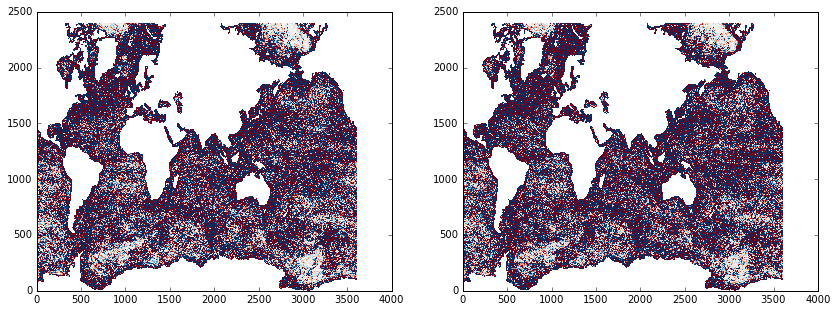

In [31]:
fig = plt.figure(figsize=(14,5))

ax1 = fig.add_subplot(121)
ax1.pcolormesh(np.ma.masked_invalid(Udiss_Jan[0] - 1e-4*np.ma.masked_values(Udiss[0], 0.)),
              cmap='RdBu_r', vmin=-1e-7, vmax=1e-7)

ax2 = fig.add_subplot(122)
ax2.pcolormesh(np.ma.masked_invalid(Vdiss_Jan[0] - 1e-4*np.ma.masked_values(Vdiss[0], 0.)),
              cmap='RdBu_r', vmin=-1e-7, vmax=1e-7)

In [ ]:
# mytup = (5, 6)
# [5 * t for t in mytup]

In [17]:
def laplacian(field, *args):
    """Returns the laplacian
    """
    if field == 'tracer':
        assert len(args)==1
        return args
    elif field == 'momentum':
        assert len(args)==2
        return args

In [18]:
T= 10.
re = laplacian('tracer', T)
print re

(10.0,)
